<a href="https://colab.research.google.com/github/agntgalahad/pothole-detection/blob/main/PotHole_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.normalization import batch_normalization
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
#Upload Kaggle api json file
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"himan1234","key":"8061c18115e8805ead9e9a4249d477a1"}'}

In [19]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset

pothole-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
import zipfile
!mkdir dataset
with zipfile.ZipFile('/content/pothole-detection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

mkdir: cannot create directory ‘dataset’: File exists


In [21]:
from pathlib import Path
import imghdr
import os

img_link=list(Path("/content/dataset/normal").glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)

Total 59 pcs image delete from Dataset


In [22]:
img_link=list(Path("/content/dataset/potholes").glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)

Total 31 pcs image delete from Dataset


In [23]:
img_height, img_width = 227, 227
batch_size = 32
data_dir = '/content/dataset'
class_names = ['normal', 'potholes']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    labels = 'inferred',
    class_names = class_names,
    label_mode = 'categorical',
    batch_size = batch_size,
    seed = 123,
    image_size=(img_height, img_width),
)
print(train_ds)

Found 591 files belonging to 2 classes.
Using 473 files for training.
<BatchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [24]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    labels = 'inferred',
    class_names = class_names,
    label_mode = 'categorical',
    batch_size = batch_size,
    seed = 123,
    image_size=(img_height, img_width),
)
print(valid_ds)

Found 591 files belonging to 2 classes.
Using 118 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [25]:
print(train_ds.class_names)

['normal', 'potholes']


In [26]:
image_shape = (227, 227, 3)

model = Sequential()

#1st Conv Layer
model.add(Conv2D(filters=96, input_shape = image_shape, kernel_size = (11,11), strides = (4,4), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
#Max Pooling
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same'))

#2nd Conv Layer 
model.add(Conv2D(filters=256, kernel_size = (5,5), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))

#MaX Pooling
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same'))

#3rd Conv Layer
model.add(Conv2D(filters=384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))

#4th Conv Layer
model.add(Conv2D(filters=384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))

#5th Conv Layer
model.add(Conv2D(filters=384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))

#Max Pooling
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same'))

#Flatten 
model.add(Flatten())

model.add(Dense(4096, input_shape = (227*227*3,)))
model.add(Activation('relu'))

#Dropout to prevent overfitting
model.add(Dropout(0.4))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 57, 57, 96)        34944     
                                                                 
 activation_8 (Activation)   (None, 57, 57, 96)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 256)       614656    
                                                                 
 activation_9 (Activation)   (None, 29, 29, 256)      

In [27]:
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'adam', metrics = ["accuracy"])

In [28]:
history = model.fit(train_ds, epochs = 15, batch_size = batch_size)

Epoch 1/15
15/15 [==============================] - 7s 220ms/step - loss: 20.5776 - accuracy: 0.4841
Epoch 2/15
15/15 [==============================] - 10s 316ms/step - loss: 0.6862 - accuracy: 0.5624
Epoch 3/15
15/15 [==============================] - 6s 185ms/step - loss: 0.6842 - accuracy: 0.6364
Epoch 4/15
15/15 [==============================] - 6s 188ms/step - loss: 0.6925 - accuracy: 0.5285
Epoch 5/15
15/15 [==============================] - 6s 186ms/step - loss: 0.6690 - accuracy: 0.5645
Epoch 6/15
15/15 [==============================] - 6s 186ms/step - loss: 0.6645 - accuracy: 0.5941
Epoch 7/15
15/15 [==============================] - 6s 212ms/step - loss: 0.5904 - accuracy: 0.6913
Epoch 8/15
15/15 [==============================] - 6s 190ms/step - loss: 0.5556 - accuracy: 0.7040
Epoch 9/15
15/15 [==============================] - 6s 190ms/step - loss: 0.6019 - accuracy: 0.6596
Epoch 10/15
15/15 [==============================] - 6s 188ms/step - loss: 0.5713 - accuracy: 0.67

In [31]:
test_history = model.evaluate(valid_ds, batch_size = batch_size, verbose=2)

4/4 - 1s - loss: 0.5320 - accuracy: 0.7458 - 754ms/epoch - 189ms/step


In [32]:
!mkdir saved_models
model.save('/content/saved_models')

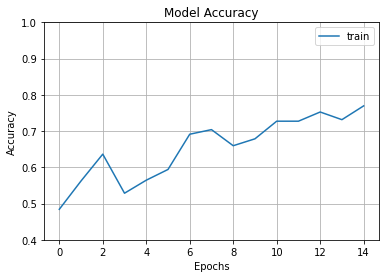

In [40]:
plt.plot(history.history['accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()